In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from cvxpy import *
from DTools3 import *
from matplotlib import gridspec
from matplotlib.patches import Rectangle
%matplotlib inline


# Data prep

Import the adult dataset, and name categories.

In [2]:
dataFolder = '../data/'

df = pd.read_csv(
    dataFolder + "adult.data",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Gender", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Income"],
        na_values="?")

In [3]:
df.shape

(32561, 15)

Group age by decade.

In [3]:
df['Age (decade)'] = df['Age'].apply(lambda x: np.floor(x/10.0)*10.0)
df['Age (decade)'] = df['Age'].apply(lambda x: np.floor(x/10.0)*10.0)

Cluster minority, education and age attributes.

In [4]:
def group_edu(x):
    if x<=5:
        return '<6'
    elif x>=13:
        return '>12'
    else:
        return x
    
def age_cut(x):
    if x>=70:
        return '>=70'
    else:
        return x

# Limit education range
df['Education Years'] = df['Education-Num'].apply(lambda x : group_edu(x))

# Limit age range
df['Age (decade)'] = df['Age (decade)'].apply(lambda x : age_cut(x))

# Transform all that is non-white into 'minority'
df['Race'] = df['Race'].apply(lambda x: x if x== ' White' else 'Minority')

# Add binary income variable
df['Income Binary'] = df['Income'].apply(lambda x : 1 if x == " >50K" else 0)

We'll be interested only in age, education, income, gender and race. Set discriminatory features (`D_features`), binary response variable (`Y_features`) and decision features (`X_features`).

In [5]:
#features = ['Age (decade)','Education Years','Income','Gender','Race','Income Binary']
features = ['Age (decade)','Education Years','Income','Gender','Income Binary']
#D_features = ['Gender','Race']
D_features = ['Gender']
Y_features = ['Income Binary']
X_features = ['Age (decade)', 'Education Years']

# keep only the features we will use
df = df[features]

Next, we do a 80-20 split of the data. The random number generator seed is fixed, so this should generate consistent splits. We automatically rename output files accordingly. Pairs of train and test dataset are stored in `df_list`.

In [6]:
from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=5, test_size=.2, random_state=888)  ### CHANGE SEED FOR DIFFERENT SPLITS!
df_list = []
for train_index,test_index in rs.split(df):
    df_list.append((df.iloc[train_index,:].copy(),df.iloc[test_index,:].copy()))
    

Now we set the distortion metric. This function will receive the two dictionary of features X and Y corresponding to the new and old values. You may want to adjust the penalties for different results. The events that receive `bad_val` are those that will never happen.

In [7]:
class Dclass():
# adjust education
    def adjustEdu(self,v):
        if v=='>12':
            return 13
        elif v=='<6':
            return 5
        else:
            return v

    def adjustAge(self,a):
        if a == '>=70':
            return 70.0
        else:
            return a

    # distortion metric
    def getDistortion(self,vold,vnew):
        '''
        Distortion metric.

        Inputs:
        *vold : dictionary of the form {attr:value} with old values
        *vnew : dictionary of the form {attr:value} with new values

        Output
        *d : distortion value
        '''

        # value that will be returned for events that should not occur
        bad_val = 3.0


        # Adjust education years
        eOld = self.adjustEdu(vold['Education Years'])
        eNew = self.adjustEdu(vnew['Education Years'])

        # Education cannot be lowered or increased in more than 1 year
        if (eNew<eOld)| (eNew>eOld+1):
            return bad_val

        # adjust age
        aOld = self.adjustAge(vold['Age (decade)'])
        aNew = self.adjustAge(vnew['Age (decade)'])

        # Age cannot be increased or decreased in more than a decade
        if np.abs(aOld-aNew)>10.0:
            return bad_val
        
        # Penalty of 2 if age is decreased or increased
        if np.abs(aOld-aNew)>0:
            return 2.0

        # final penalty according to income
        if vold['Income Binary']>vnew['Income Binary']:
            return 1.0
        else:
            return 0.0
        

Here we adjust the cost constraints. For the adult dataset, we control the probability of certain mappings happening. You may not want to change this now, since it matches the paper.

In [8]:
c1 = .99 # value of (delta1,c1): to keep.
c2 = 1.99  # value of (delta2,c2): value that should no happen
c3 = 2.99 # penalty for adjusting age
clist = [c1,c2, c3]
Dclass = Dclass()

DT = DTools(df=df,features=features)

# Set features
DT.setFeatures(D=D_features,X=X_features,Y=Y_features)

# Set Distortion
DT.setDistortion(Dclass,clist=clist)

The next code is important -- it can help you explore values of constraints that will not lead to infeasible solutions. Dlist constrols distortion (see more info below). The red region is infeasible.

  0%|          | 0/10 [00:00<?, ?it/s]DTools3.py:235: RuntimeWarning: divide by zero encountered in reciprocal
  Pxy_xhyh = np.nan_to_num(np.diag(PxyMarginal**(-1))).dot(self.dfMask_Pxyd_to_Pxy.values.T).dot(np.diag(PxydMarginal))*Pmap
100%|██████████| 10/10 [00:10<00:00,  1.13s/it]


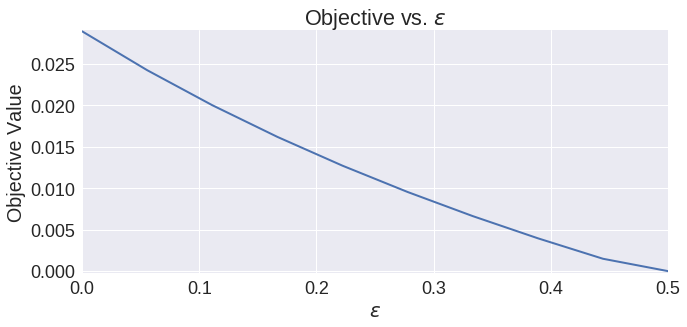

In [9]:
dlist = [.1,0.05,0]
#dlist = [.2,0.15,0.05]



epsilonV = np.linspace(0,.5,10)
y = np.zeros(len(epsilonV))
z = np.zeros(len(epsilonV))

for i in tqdm(range(len(epsilonV))):
    try:
        DT.optimize(epsilon=epsilonV[i],dlist = dlist,verbose=False)
    except:
        y[i] = np.inf
        z[i] = np.inf
        continue
        
    y[i] = DT.optimum
    z[i] = DT.const[0]
    
# Plot
sns.set(font_scale=1.8,font='sans-serif')
plt.figure(figsize = (10,5))
ax = plt.plot(epsilonV,y,'-',linewidth=2)
plt.ylabel("Objective Value")
plt.xlabel("$\epsilon$")
plt.title("Objective vs. $\epsilon$")# for\n$\delta_1 =$"+str(dlist[0])+", $\delta_2=$"+str(dlist[1])+" and $\delta_3=$"+str(dlist[2]))
infeasible = np.where(y==np.inf)[0]
if infeasible:
    plt.axvspan(0, epsilonV[infeasible[-1]+1], color='red', alpha=0.2)
plt.xlim([epsilonV.min(),epsilonV.max()])
plt.ylim([-0.0002,y[y<np.inf].max()+0.0001])

#plt.text(0.05, 0.0075, r'Infeasible', fontsize=20)
plt.tight_layout()

These are the values you may want to change. dlist has three parameters that control distortion. The last one should be left at 0, but the first two can be tweeked (as long as dlist[0]$\geq$dlist[1]). We use the same distortion across protected varialbes.

The second value is the discrimination constraint. We use two values .05 and .1 for generating two sets of experimental datasets.

In [10]:
# these were the values used in the paper
dlist = [.1,0.05,0]
epsilon = .05
#epsilon=.1

This is an auxiliary function for helping in randomizing the dataset. It receives a dataset and a mapping, and randomizes accordingly. I'm fixing the value of the seed for numpy -- you may want to change this in order to produce fresh datasets.

In [11]:
######### CHANGE SEED HERE ###########
seed = sum([ord(b) for b in 'Bhanu'])
np.random.seed(seed = seed)
####################################

def randomize(df, dfMap,features=[]):
    df2 = df.copy()
    print('Randomizing...')
    for idx in tqdm(df2.index):
        rowTest = df2.loc[idx,:]
        vals = rowTest[features]
        draw = dfMap.loc[tuple(vals.tolist())]
        #randomly select value

        mapVal = np.random.choice(range(len(draw)),p=draw.tolist())
        draw.index[mapVal]
        df2.loc[idx,draw.index.names] = draw.index[mapVal]
        
    return df2


## Main loop

This is where the brute of the work will be done. May take a while to run, and will print randomization progress.

In [12]:
result_folder = '../experiment_data1/'
split_num = 0

# iterate over pairs
for (df_train,df_test) in df_list:
    file_name = str(split_num)
    
    print('-----------------')
    print('Current split: '+file_name)

    # initialize a new DT object
    DT = DTools(df=df_train,features=features)

    # Set features
    DT.setFeatures(D=D_features,X=X_features,Y=Y_features)

    # Set Distortion
    DT.setDistortion(Dclass,clist=clist)

    # solve optimization for previous parameters -- This uses and older implementation, based on the FATML submission.
    DT.optimize(epsilon=epsilon,dlist = dlist,verbose=False)

    DT.computeMarginals()

    # randomized mapping for training
    # this is the dataframe with the randomization for the train set
    dfPtrain = DT.dfP.applymap(lambda x : 0 if x<1e-8 else x)
    dfPtrain = dfPtrain.divide(dfPtrain.sum(axis=1),axis=0)

    # randomized mapping for testing (Beware of ugly code)
    d1 = DT.dfFull.reset_index().groupby(D_features+X_features).sum()
    d2 = d1.transpose().reset_index().groupby(X_features).sum()
    dTest = d2.transpose()
    dTest = dTest.drop(Y_features,1)
    dTest = dTest.applymap(lambda x: x if x>1e-8 else 0)
    dTest = dTest/dTest.sum()

    # this is the dataframe with the randomization for the test set
    dfPtest = dTest.divide(dTest.sum(axis=1),axis=0)

    # Randomize train data
    print('Randomizing training set...')
    df_train_new = randomize(df_train,dfPtrain,features = D_features+X_features+Y_features)

    # Randomize test data
    print('Randomizing test set...')
    df_test_new = randomize(df_test,dfPtest,features = D_features+X_features)

    # Save train files
    df_train.to_csv(result_folder+'train_'+file_name+'.csv')
    df_train_new.to_csv(result_folder+'train_new_'+file_name+'.csv')

    # Save test files
    df_test.to_csv(result_folder+'test_'+file_name+'.csv')
    df_test_new.to_csv(result_folder+'test_new_'+file_name+'.csv')
    
    # increment split number
    split_num+=1

-----------------
Current split: 0


/home/bhanu/anaconda3/envs/python2/lib/python2.7/site-packages/pandas/core/base.py:324: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  return self.obj.drop(self.exclusions, axis=1)
  0%|          | 33/26048 [00:00<01:19, 327.70it/s]

Randomizing training set...
Randomizing...


  1%|          | 52/6513 [00:00<00:12, 519.16it/s]

Randomizing test set...
Randomizing...


100%|██████████| 6513/6513 [00:11<00:00, 546.91it/s]


-----------------
Current split: 1


  0%|          | 33/26048 [00:00<01:20, 322.92it/s]

Randomizing training set...
Randomizing...


  1%|          | 52/6513 [00:00<00:12, 516.38it/s]

Randomizing test set...
Randomizing...


100%|██████████| 6513/6513 [00:12<00:00, 540.36it/s]


-----------------
Current split: 2


  0%|          | 33/26048 [00:00<01:20, 323.20it/s]

Randomizing training set...
Randomizing...


  1%|          | 53/6513 [00:00<00:12, 526.08it/s]

Randomizing test set...
Randomizing...


100%|██████████| 6513/6513 [00:12<00:00, 541.76it/s]


-----------------
Current split: 3


  0%|          | 33/26048 [00:00<01:20, 322.12it/s]

Randomizing training set...
Randomizing...


  1%|          | 50/6513 [00:00<00:13, 492.89it/s]

Randomizing test set...
Randomizing...


100%|██████████| 6513/6513 [00:12<00:00, 536.73it/s]


-----------------
Current split: 4


  0%|          | 32/26048 [00:00<01:22, 314.41it/s]

Randomizing training set...
Randomizing...


  1%|          | 53/6513 [00:00<00:12, 526.21it/s]

Randomizing test set...
Randomizing...


100%|██████████| 6513/6513 [00:11<00:00, 543.16it/s]


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# original performance on train data
print '----------------------------------------------------------------'
print 'LogReg original data (with disc. variable):'
rf = LogisticRegression()
dft = pd.get_dummies(df_train[D_features+X_features])
rf.fit(dft,df_train[Y_features])
print 'Train performance: (original dataset)'
print rf.score(dft,df_train[Y_features])

# df_train_pred = df_train
# df_train_pred['pred'] = rf.predict(dft)

# # prediction per class
# print df_train_pred.groupby(D_features)['pred'].mean()

dft = pd.get_dummies(df_test[D_features+X_features])
print 'Test performance (original dataset): '
print rf.score(dft,df_test[Y_features])

print 'Test classification result:'
# save performance
df_test_pred = df_test
df_test_pred['pred'] = rf.predict_proba(dft)[:,1]

# prediction per class
print df_test_pred.groupby(D_features)['pred'].mean()



print '----------------------------------------------------------------'
print 'LogReg on perturbed data:'

# performance on perturbed train data
rf = LogisticRegression()
dft = pd.get_dummies(df_train_new[D_features+X_features])
rf.fit(dft,df_train_new[Y_features])
print 'Train performance (pert. dataset): '
print rf.score(dft,df_train_new[Y_features])

df_train_pred = df_train_new
df_train_pred['pred'] = rf.predict_proba(dft)[:,1]

print df_train_pred.groupby(D_features)['pred'].mean()

print 'Train discrimination ratios result:'
mean = df_train_pred.groupby(D_features)['pred'].mean()
v = mean.values
v = v.reshape(len(v),1)
ratio_df = pd.DataFrame(v/v.transpose(),index=mean.index,columns=mean.index )
print ratio_df

# performance on perturbed train data compared to original train data
#rf = RandomForestClassifier()
#dft = pd.get_dummies(df_train_new[D_features+X_features])
#rf.fit(dft,df_train_new[Y_features])
dft = pd.get_dummies(df_test_new[D_features+X_features])
print 'Perturbed test performance when scored on original test y variable: '
print rf.score(dft,df_test[Y_features])

dft = pd.get_dummies(df_test_new[D_features+X_features])
# save performance
df_test_pred = df_test_new
df_test_pred['pred'] = rf.predict_proba(dft)[:,1]

# prediction per class
print 'Test classification result:'
print df_test_pred.groupby(D_features)['pred'].mean()

# test discrimination ratios
# This is what pyhgd will look like for y=1
print 'Test discrimination ratios result:'
mean = df_test_pred.groupby(D_features)['pred'].mean()
v = mean.values
v = v.reshape(len(v),1)
ratio_df = pd.DataFrame(v/v.transpose(),index=mean.index,columns=mean.index )
print ratio_df


# compared to dropping feature
print '----------------------------------------------------------------'
print 'LogReg original data (DROPPING disc. variable):'
rf = LogisticRegression()
dft = pd.get_dummies(df_train[X_features])
rf.fit(dft,df_train[Y_features])
print 'Dropping D train performance: '
print rf.score(dft,df_train[Y_features])

df_train_pred = df_train
df_train_pred['pred'] = rf.predict_proba(dft)[:,1]

# prediction per class
print df_train_pred.groupby(D_features)['pred'].mean()

print 'Train discrimination ratios result:'
mean = df_train_pred.groupby(D_features)['pred'].mean()
v = mean.values
v = v.reshape(len(v),1)
ratio_df = pd.DataFrame(v/v.transpose(),index=mean.index,columns=mean.index )
print ratio_df

dft = pd.get_dummies(df_test[X_features])
print 'Dropping D test performance: '
print rf.score(dft,df_test[Y_features])
print 'Test classification result:'
# save performance
df_test_pred = df_test
df_test_pred['pred'] = rf.predict_proba(dft)[:,1]

# prediction per class
print df_test_pred.groupby(D_features)['pred'].mean()

print 'Test discrimination ratios result:'
mean = df_test_pred.groupby(D_features)['pred'].mean()
v = mean.values
v = v.reshape(len(v),1)
ratio_df = pd.DataFrame(v/v.transpose(),index=mean.index,columns=mean.index )
print ratio_df


# compared to dropping feature
print '----------------------------------------------------------------'
print 'LogReg perturbed data (DROPPING disc. variable):'
rf = LogisticRegression()
dft = pd.get_dummies(df_train_new[X_features])
rf.fit(dft,df_train_new[Y_features])
print 'Dropping D train performance: '
print rf.score(dft,df_train[Y_features])

df_train_pred = df_train_new
df_train_pred['pred'] = rf.predict_proba(dft)[:,1]

# prediction per class
print df_train_pred.groupby(D_features)['pred'].mean()

dft = pd.get_dummies(df_test_new[X_features])
print 'Dropping D test performance: '
print rf.score(dft,df_test_new[Y_features])
print 'Test classification result:'
# save performance
df_test_pred = df_test_new
df_test_pred['pred'] = rf.predict_proba(dft)[:,1]

# prediction per class
print df_test_pred.groupby(D_features)['pred'].mean()

----------------------------------------------------------------
LogReg original data (with disc. variable):
Train performance: (original dataset)
0.802902334152
Test performance (original dataset): 
0.807615538154
Test classification result:
Gender
 Female    0.111410
 Male      0.304762
Name: pred, dtype: float64
----------------------------------------------------------------
LogReg on perturbed data:
Train performance (pert. dataset): 
0.767122235872
Gender
 Female    0.256933
 Male      0.268406
Name: pred, dtype: float64
Train discrimination ratios result:
Gender     Female      Male
Gender                     
 Female  1.000000  0.957254
 Male    1.044655  1.000000
Perturbed test performance when scored on original test y variable: 
0.773069246123
Test classification result:
Gender
 Female    0.271147
 Male      0.271364
Name: pred, dtype: float64
Test discrimination ratios result:
Gender     Female      Male
Gender                     
 Female  1.000000  0.999202
 Male    1.000

/home/bhanu/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Dropping D train performance: 
0.785741707617
Gender
 Female    0.214838
 Male      0.255676
Name: pred, dtype: float64
Train discrimination ratios result:
Gender    Female      Male
Gender                    
 Female  1.00000  0.840272
 Male    1.19009  1.000000
Dropping D test performance: 
0.790265622601
Test classification result:
Gender
 Female    0.214587
 Male      0.254118
Name: pred, dtype: float64
Test discrimination ratios result:
Gender     Female      Male
Gender                     
 Female  1.000000  0.844439
 Male    1.184217  1.000000
----------------------------------------------------------------
LogReg perturbed data (DROPPING disc. variable):
Dropping D train performance: 
0.78363022113
Gender
 Female    0.242450
 Male      0.275557
Name: pred, dtype: float64
Dropping D test performance: 
0.776293566713
Test classification result:
Gender
 Female    0.256349
 Male      0.278693
Name: pred, dtype: float64


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# original performance on train data
print '----------------------------------------------------------------'
print 'RandForrest original data (with disc. variable):'
rf = RandomForestClassifier()
dft = pd.get_dummies(df_train[D_features+X_features])
rf.fit(dft,df_train[Y_features])
print 'Train performance: (original dataset)'
print rf.score(dft,df_train[Y_features])

# df_train_pred = df_train
# df_train_pred['pred'] = rf.predict(dft)

# # prediction per class
# print df_train_pred.groupby(D_features)['pred'].mean()

dft = pd.get_dummies(df_test[D_features+X_features])
print 'Test performance (original dataset): '
print rf.score(dft,df_test[Y_features])

print 'Test classification result:'
# save performance
df_test_pred = df_test
df_test_pred['pred'] = rf.predict_proba(dft)[:,1]

# prediction per class
print df_test_pred.groupby(D_features)['pred'].mean()



print '----------------------------------------------------------------'
print 'RandForrest on perturbed data:'

# performance on perturbed train data
rf = RandomForestClassifier()
dft = pd.get_dummies(df_train_new[D_features+X_features])
rf.fit(dft,df_train_new[Y_features])
print 'Train performance (pert. dataset): '
print rf.score(dft,df_train_new[Y_features])

df_train_pred = df_train_new
df_train_pred['pred'] = rf.predict_proba(dft)[:,1]

print df_train_pred.groupby(D_features)['pred'].mean()

print 'Train discrimination ratios result:'
mean = df_train_pred.groupby(D_features)['pred'].mean()
v = mean.values
v = v.reshape(len(v),1)
ratio_df = pd.DataFrame(v/v.transpose(),index=mean.index,columns=mean.index )
print ratio_df

# performance on perturbed train data compared to original train data
#rf = RandomForestClassifier()
#dft = pd.get_dummies(df_train_new[D_features+X_features])
#rf.fit(dft,df_train_new[Y_features])
dft = pd.get_dummies(df_test_new[D_features+X_features])
print 'Perturbed test performance when scored on original test y variable: '
print rf.score(dft,df_test[Y_features])

dft = pd.get_dummies(df_test_new[D_features+X_features])
# save performance
df_test_pred = df_test_new
df_test_pred['pred'] = rf.predict_proba(dft)[:,1]

# prediction per class
print 'Test classification result:'
print df_test_pred.groupby(D_features)['pred'].mean()

# test discrimination ratios
# This is what pyhgd will look like for y=1
print 'Test discrimination ratios result:'
mean = df_test_pred.groupby(D_features)['pred'].mean()
v = mean.values
v = v.reshape(len(v),1)
ratio_df = pd.DataFrame(v/v.transpose(),index=mean.index,columns=mean.index )
print ratio_df

ratio_df_arr=np.asarray(np.abs(1-ratio_df))
print 'Test discrimination value:'
print np.amax(ratio_df_arr)


# compared to dropping feature
print '----------------------------------------------------------------'
print 'RandForrest original data (DROPPING disc. variable):'
rf = RandomForestClassifier()
dft = pd.get_dummies(df_train[X_features])
rf.fit(dft,df_train[Y_features])
print 'Dropping D train performance: '
print rf.score(dft,df_train[Y_features])

df_train_pred = df_train
df_train_pred['pred'] = rf.predict_proba(dft)[:,1]

# prediction per class
print df_train_pred.groupby(D_features)['pred'].mean()

print 'Train discrimination ratios result:'
mean = df_train_pred.groupby(D_features)['pred'].mean()
v = mean.values
v = v.reshape(len(v),1)
ratio_df = pd.DataFrame(v/v.transpose(),index=mean.index,columns=mean.index )
print ratio_df

dft = pd.get_dummies(df_test[X_features])
print 'Dropping D test performance: '
print rf.score(dft,df_test[Y_features])
print 'Test classification result:'
# save performance
df_test_pred = df_test
df_test_pred['pred'] = rf.predict_proba(dft)[:,1]

# prediction per class
print df_test_pred.groupby(D_features)['pred'].mean()

print 'Test discrimination ratios result:'
mean = df_test_pred.groupby(D_features)['pred'].mean()
v = mean.values
v = v.reshape(len(v),1)
ratio_df = pd.DataFrame(v/v.transpose(),index=mean.index,columns=mean.index )
print ratio_df



# compared to dropping feature
print '----------------------------------------------------------------'
print 'RandForrest perturbed data (DROPPING disc. variable):'
rf = RandomForestClassifier()
dft = pd.get_dummies(df_train_new[X_features])
rf.fit(dft,df_train_new[Y_features])
print 'Dropping D train performance: '
print rf.score(dft,df_train[Y_features])

df_train_pred = df_train_new
df_train_pred['pred'] = rf.predict(dft)

# prediction per class
print df_train_pred.groupby(D_features)['pred'].mean()

dft = pd.get_dummies(df_test_new[X_features])
print 'Dropping D test performance: '
print rf.score(dft,df_test_new[Y_features])
print 'Test classification result:'
# save performance
df_test_pred = df_test_new
df_test_pred['pred'] = rf.predict_proba(dft)[:,1]

# prediction per class
print df_test_pred.groupby(D_features)['pred'].mean()

----------------------------------------------------------------
RandForrest original data (with disc. variable):
Train performance: (original dataset)
0.802979115479
Test performance (original dataset): 
0.807922616306
Test classification result:
Gender
 Female    0.110243
 Male      0.305952
Name: pred, dtype: float64
----------------------------------------------------------------
RandForrest on perturbed data:
Train performance (pert. dataset): 
0.772688882064
Gender
 Female    0.254944
 Male      0.269238
Name: pred, dtype: float64
Train discrimination ratios result:
Gender     Female      Male
Gender                     
 Female  1.000000  0.946909
 Male    1.056068  1.000000
Perturbed test performance when scored on original test y variable: 
0.739137110395
Test classification result:
Gender
 Female    0.344436
 Male      0.268964
Name: pred, dtype: float64
Test discrimination ratios result:
Gender     Female      Male
Gender                     
 Female  1.000000  1.280604
 Mal